In [1]:
import pybedtools as pb
import numpy as np
#import scipy
import pandas as pd
#import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/home/sergio/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sergio/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sergio/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Load enhancers 

In [2]:
enh = pb.BedTool('tracks/Enhancers_ChromHMM.bed')
enh_df = enh.to_dataframe()

## Load peaks and filter by score

In [3]:
tlx_pk = pb.BedTool('tracks/TLX3_TLX3_peaks.bed')
tlx_df =tlx_pk.to_dataframe(names=['chr','start','end','name','score'])

shr = 100
top = tlx_df[tlx_df['score']>shr].sort_values('score', axis=0, ascending=False)
tlx_top = pb.BedTool.from_dataframe(top)

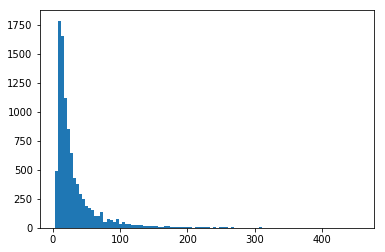

In [4]:
#a,b,c = plt.hist(np.log(tlx_df['score']), bins=100)
a,b,c = plt.hist(tlx_df['score'], bins=100)

## Intersect enhancers and high score peaks

In [5]:
enh_tlx_top = enh+tlx_top 

In [41]:
enh_tlx_top.head()

chr1	36320400	36321200	enh_89
 chr1	36350200	36352400	enh_94
 chr1	36353200	36354800	enh_95
 chr1	43618000	43620000	enh_222
 chr1	43936600	43937400	enh_231
 chr1	44178800	44179800	enh_239
 chr1	51641000	51642000	enh_257
 chr1	53907800	53909200	enh_300
 chr1	60759400	60760600	enh_371
 chr1	97347400	97348200	enh_664
 

## Load WGS variants

In [6]:
path = 'tracks/WGS-WES/Germline/'
ftlx = 'tracks/WGS-WES/Germline/FERRIER_09_Germline.allchr.snpEff.p.SAL.SAL10_1.vcf'
var_b = pb.BedTool(ftlx)

## Find variants in enhancers with TLX3 peaks

In [7]:
var_ehn_tlx = var_b+enh_tlx_top

In [8]:
var_ehn_tlx_df = var_ehn_tlx.to_dataframe(names=['CHROM','POS','ID','REF','ALT','QUAL','FILTER','INFO','FORMAT','AC3812','AC3813','AC3814','AC3815'])

In [18]:
#var_ehn_tlx_df.head(10)
len(var_ehn_tlx_df)

136

In [11]:
# Enhancers Table manipulation
enh2gn = pd.read_table('tracks/Enhancers_ChromHMM_enh2genes.txt', 
                        header=1, 
                        names=['enhancers','gene_name'])

In [12]:
enh_tlx_top_df = enh_tlx_top.to_dataframe()

In [13]:
enh_nm = list(enh_tlx_top_df['name'])

In [14]:
enh2gn_top = enh2gn[enh2gn['enhancers'].isin(enh_nm)]

In [15]:
a = list()
for i in range(len(enh2gn_top )):
    ls = enh2gn_top['gene_name'].iloc[i].split(', ')
    a=a+[tr.split(' (')[0] for tr in ls]


In [16]:
len(set(a))

371

# Enrichment

In [19]:

import EnrichRLib as erl
# List of gene sets as above
gss = [ 
       'GO_Biological_Process_2018',
       'GO_Cellular_Component_2018',
       'GO_Molecular_Function_2018',
       'KEGG_2016',
       'Reactome_2016'
       ]

In [20]:
a = [x.upper() for x in a]

enr_a = erl.enrich_gs(a,gss)



GO_Biological_Process_2018 2048
GO_Cellular_Component_2018 200
GO_Molecular_Function_2018 421
KEGG_2016 215
Reactome_2016 648


Text(0.5,1,'Genes regulated by enhancers with high Tlx3 peaks')

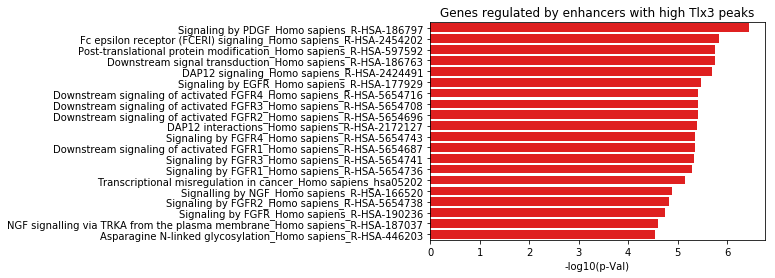

In [22]:
# --- Plot ---
enr_a.sort_values('p-Val', axis=0, inplace = True)
ds = enr_a.head(20)

f, ax = plt.subplots()
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            color="Red", 
            data = ds)
ax.set_title('Genes regulated by enhancers with high Tlx3 peaks')

# Expression analysis

In [25]:
import RNA_expression_processing as rn
from os.path import join

In [32]:
tbl = pd.read_table(join('tracks', 'TLX3vsRAG-results_genesNames.txt'), index_col=0)
#tbl = tbl[(tbl.padj < 0.05)].dropna()

# === Pheno ==
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3


cols = ['Gene_name', 'TLX3.1_1','TLX3.1_5','TLX3.1_P','R2.RAG1W.RAG1','RAGS.RAGZ','RAGZ']

tbn = tbl[cols]
tbv = tbn.set_index(keys=tbn.columns[0])
tbv.index=tbv.index.str.upper()



In [33]:

### == UP analysis

tbu = tbv.iloc[tbv.index.isin(a)]


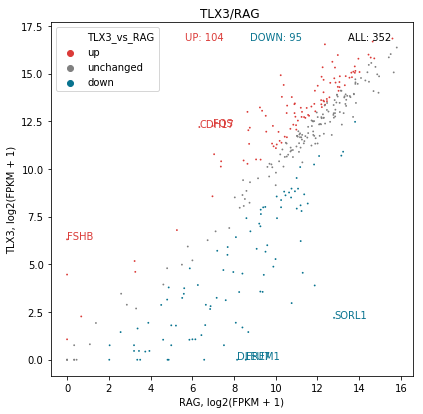

In [38]:
jj,kk,ll=rn.scatter_n(tbu, A, B, classes, n_top=3, ttl='') 

Text(0.5,1,'Cluster TLX3/RAG')

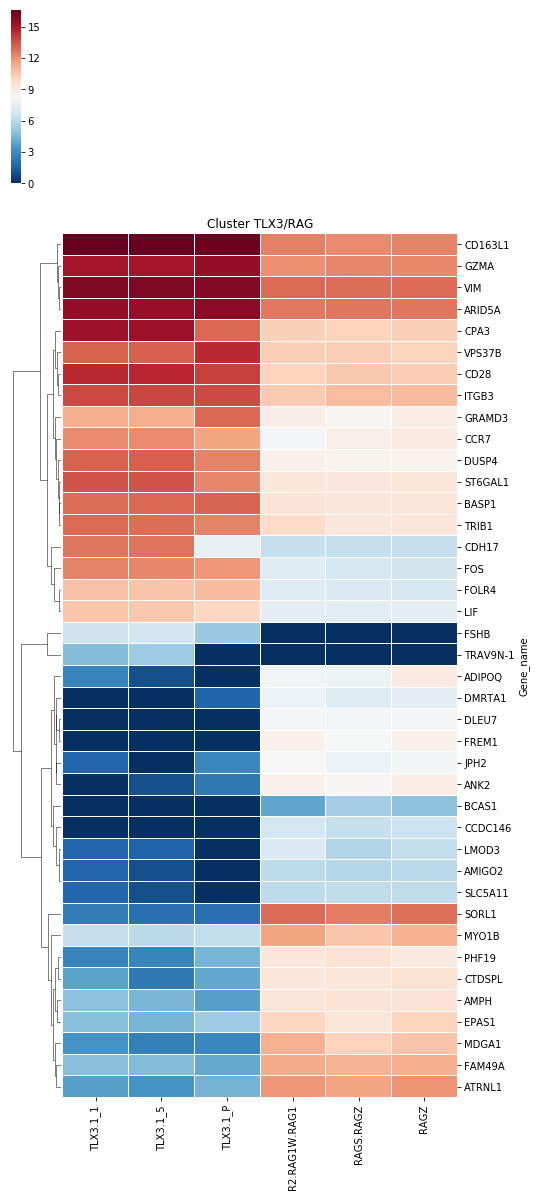

In [40]:
ntop=40
gr = rn.cluster(tbu, A, B, classes, n_top=ntop)
gr.ax_heatmap.set_title('Cluster '+A+'/'+B)